<a href="https://colab.research.google.com/github/thisisphume/ETF_Analysis_Testing/blob/main/ETF_Analysis_Data_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
### Data Retrival
import bs4 as bs
import requests

### Other
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt

from tqdm import tqdm
from numpy.linalg import inv
import math
import pandas_datareader as web

from util import stock_price_retrieval

***
# Getting the data and data cleaning

In [26]:
###################################################
### Retrieving the list of ETF: Top 100 ETFs by trading volume

resp = requests.get('https://etfdb.com/compare/volume/')
soup = bs.BeautifulSoup(resp.text, 'lxml')
table = soup.find('table', {'class': 'table'})

etf_list = []
for row in table.findAll('tr')[1:]:
    ticker = row.findAll('td')[0].text
    etf_list.append(ticker)
etf_list = [s.replace('\n', '').replace(".", "-")  for s in etf_list]

print ([x for x in etf_list])

['SPY', 'SQQQ', 'XLF', 'EEM', 'UVXY', 'QQQ', 'VXX', 'XLE', 'SPXS', 'TQQQ', 'HYG', 'SLV', 'EWZ', 'IWM', 'SPXU', 'GDX', 'EFA', 'IAU', 'TZA', 'FXI', 'IEMG', 'LQD', 'SDS', 'XLU', 'XLI', 'VWO', 'SH', 'TLT', 'SDOW', 'TNA', 'QID', 'KRE', 'GLD', 'XLP', 'XLV', 'XLK', 'IEFA', 'XOP', 'VEA', 'GDXJ', 'SPXL', 'JNK', 'BKLN', 'EWJ', 'SRTY', 'XLB', 'JDST', 'IYR', 'EWG', 'JETS', 'EWH', 'AGG', 'IEF', 'GOVT', 'PFF', 'USO', 'SJNK', 'UPRO', 'EZU', 'ERX', 'RSX', 'BND', 'UNG', 'VIXY', 'ICLN', 'UCO', 'PSQ', 'DUST', 'IJR', 'EMB', 'XBI', 'VNQ', 'INDA', 'VGK', 'EWU', 'EWT', 'EWY', 'IVV', 'FAZ', 'XLRE', 'ACWI', 'MCHI', 'SCO', 'VTI', 'DIA', 'DFEN', 'GUSH', 'XRT', 'AMLP', 'EWA', 'ITB', 'ARKK', 'ASHR', 'KBE', 'USMV', 'XLY', 'PGX', 'XLC', 'VXUS', 'FEZ']


In [267]:
######################################################

### Retrieving the historical data
eft_close = stock_price_retrieval(etf_list, '1356998400',  '1577836800', "1wk", "Adj Close") #2013-01-01 - 2020-01-01
print ("Number of Missing data: ", len(eft_close.isna().any()[eft_close.isna().any() == True]))


### Removing security that has the missing data
# Get error stock
remove_etf = eft_close.isna().any()[eft_close.isna().any() == True].index.tolist()
# Dropping the stock that has a lot of missing data
eft_close = eft_close.drop(columns=remove_etf)
# Check if there is any missing data
print ("Any missing data left: ", eft_close.isnull().values.any())

ERROR:  UVXY
ERROR:  VIXY
Number of Missing data:  9
Any missing data left:  False


,SPY,SQQQ,XLF,EEM,QQQ,XLE,SPXS,TQQQ,HYG,SLV,EWZ,IWM,SPXU,GDX,EFA,IAU,TZA,FXI,IEMG,LQD,SDS,XLU,XLI,VWO,SH,TLT,SDOW,TNA,QID,KRE,GLD,XLP,XLV,XLK,IEFA,XOP,VEA,GDXJ,SPXL,JNK,...,GOVT,PFF,USO,SJNK,UPRO,EZU,ERX,RSX,BND,UNG,ICLN,UCO,PSQ,DUST,IJR,EMB,XBI,VNQ,INDA,VGK,EWU,EWT,EWY,IVV,FAZ,ACWI,MCHI,SCO,VTI,DIA,XRT,AMLP,EWA,ITB,KBE,USMV,XLY,PGX,VXUS,FEZ
mean_return,0.002606,-0.009541,0.004542,-0.000332,0.003241,0.001051,-0.007978,0.009535,0.000737,-0.002552,-0.000898,0.002659,-0.007708,-0.001830,0.000881,-0.001505,-0.008557,0.000285,-0.000228,0.000551,-0.005210,0.00242,0.002867,-0.000117,-0.002694,0.000690,-0.007424,0.007724,-0.006467,0.003833,-0.001535,0.002417,0.003004,0.002953,0.000983,0.000060,0.000975,-0.001663,0.007468,0.000637,...,0.000205,0.000851,-0.003960,0.000572,0.007517,0.001018,0.002880,-0.000122,0.000345,-0.001972,0.001340,-0.007866,-0.003342,0.001121,0.003076,0.000461,0.004404,0.002072,0.000779,0.000849,0.000396,0.001272,-0.000153,0.002629,-0.009072,0.001566,0.000407,0.006891,0.002611,0.002483,0.002068,0.000662,0.000286,0.001614,0.003394,0.002550,0.002979,0.001020,0.000664,0.000794
std_return,0.018098,0.067017,0.030235,0.029096,0.021823,0.030407,0.055778,0.064897,0.010782,0.034826,0.047664,0.023400,0.055857,0.057737,0.023044,0.022903,0.069657,0.034077,0.027833,0.007800,0.036941,0.02015,0.020966,0.029775,0.018384,0.016766,0.053190,0.070548,0.044367,0.029385,0.022858,0.015971,0.020453,0.020524,0.022472,0.050454,0.022231,0.070276,0.054331,0.010817,...,0.004778,0.009753,0.048128,0.007445,0.054202,0.026290,0.091119,0.044448,0.004705,0.050778,0.034111,0.095080,0.022086,0.173700,0.022135,0.013487,0.049228,0.023047,0.031836,0.024015,0.027466,0.028911,0.027107,0.018614,0.062749,0.020374,0.033126,0.094886,0.018933,0.017580,0.023551,0.036467,0.030820,0.031558,0.028726,0.015275,0.020672,0.010191,0.022402,0.026191


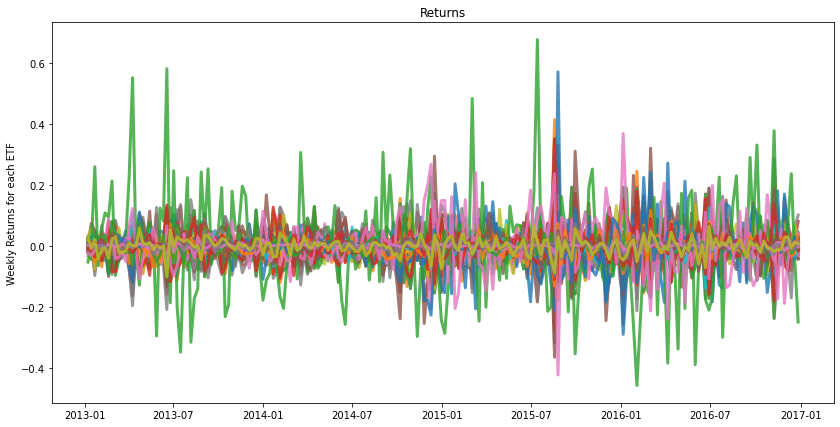

In [273]:
### Splitting the training and testing set
train = eft_close[eft_close.index < '2017-01-01']
test = eft_close[eft_close.index >= '2017-01-01']

### Getting the return from the closing price
returns = train.pct_change()
returns = returns[returns.iloc[:,1].notna()] # remove first row Null

### Plotting
plt.figure(figsize=(14, 7))
for c in returns.columns.values: plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.ylabel('Weekly Returns for each ETF') # plt.legend(loc='upper left', fontsize=10, )
plt.title("Returns")

### Basic Descriptive of the returns
mean_returns = returns.mean()
std_returns = returns.std()
cov_matrix = returns.cov()
pd.DataFrame({'mean_return':mean_returns, 'std_return':std_returns}, index= mean_returns.index).T

In [269]:
######################################################
### Historical Data Overview
eft_close.head(5)

,SPY,SQQQ,XLF,EEM,QQQ,XLE,SPXS,TQQQ,HYG,SLV,EWZ,IWM,SPXU,GDX,EFA,IAU,TZA,FXI,IEMG,LQD,SDS,XLU,XLI,VWO,SH,TLT,SDOW,TNA,QID,KRE,GLD,XLP,XLV,XLK,IEFA,XOP,VEA,GDXJ,SPXL,JNK,...,GOVT,PFF,USO,SJNK,UPRO,EZU,ERX,RSX,BND,UNG,ICLN,UCO,PSQ,DUST,IJR,EMB,XBI,VNQ,INDA,VGK,EWU,EWT,EWY,IVV,FAZ,ACWI,MCHI,SCO,VTI,DIA,XRT,AMLP,EWA,ITB,KBE,USMV,XLY,PGX,VXUS,FEZ
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-01-01,124.842438,11537.091797,9.121626,37.587963,61.564568,54.989166,383.136902,4.595988,61.194008,29.180000,46.036983,77.920135,539.941040,42.187675,45.368153,16.020000,961.061218,33.383823,43.441982,92.403206,199.340546,26.834965,33.184258,36.120316,64.445778,97.154282,996.542725,16.880133,433.646942,24.937214,159.429993,28.763752,35.949192,25.897137,41.178051,200.614441,27.990038,72.840767,7.378622,77.886978,...,22.174713,25.383791,271.359985,19.688673,7.726276,27.149986,491.010498,22.328424,67.405449,73.599998,6.256236,7560.0,97.060020,21440.470703,36.067032,84.572449,30.231064,48.136253,24.461710,37.463726,26.196733,22.168880,55.148674,124.739883,1060.586426,41.116673,42.545609,19.559999,64.642059,111.607094,28.565752,45.556530,17.813765,21.335655,21.397850,25.193390,43.602238,9.338875,37.572315,27.383247
2013-01-08,125.697685,11386.500977,9.148437,37.596367,61.850891,55.289566,375.052765,4.654175,61.395607,30.040001,45.891239,78.350479,529.432739,42.899029,46.073795,16.219999,945.370483,33.400002,43.483242,92.487366,196.590225,26.789476,33.431320,36.224922,64.018082,98.031891,966.410400,17.136038,429.797119,24.690559,161.539993,29.135721,36.632610,25.844391,41.715950,201.658249,28.447725,73.935570,7.536382,78.133438,...,22.245567,25.485348,274.239990,19.727133,7.859193,27.816347,497.763672,22.328424,67.493996,75.919998,6.347994,7725.0,96.593002,20332.955078,36.170204,83.800705,31.150192,48.337215,24.986158,38.189175,26.312265,22.333340,55.069977,125.624245,1040.931396,41.487095,42.425278,19.150000,65.054634,112.760651,28.561228,46.051994,17.904938,21.335655,21.252178,25.430748,43.943104,9.376659,38.048515,28.197474
2013-01-15,126.860855,11328.108398,9.196698,37.697388,61.952499,56.693958,364.274017,4.681606,61.610256,30.809999,46.020775,79.408409,515.061096,42.785210,46.105518,16.389999,904.574463,33.715317,43.540997,92.341995,192.832718,27.054861,34.019184,36.313431,63.395981,98.458397,938.141846,17.824085,428.103119,25.166853,163.089996,29.499617,36.956791,25.835600,41.788212,205.869171,28.455614,74.774910,7.746728,78.360985,...,22.254412,25.605909,278.160004,19.765604,8.090776,27.913857,535.374878,22.506222,67.566490,80.400002,6.297945,7945.0,96.437325,20492.044922,36.793667,84.200333,30.978670,48.868317,25.557434,38.196815,26.211178,22.119541,54.606548,126.806137,1024.421265,41.748081,42.794868,18.555000,65.750809,113.763847,29.595797,46.519955,18.073259,21.983652,21.526400,25.617235,44.687592,9.357767,38.104069,28.086802
2013-01-22,128.348999,11285.083984,9.330764,36.914486,62.026409,57.647743,351.780426,4.688256,61.662258,29.850000,45.834560,80.690521,496.980591,39.342289,46.573318,16.090000,860.640198,33.117008,42.674633,91.829254,188.571671,27.456745,34.504814,35.589252,62.696106,96.457085,887.972900,18.729416,426.717255,25.294432,160.289993,29.750307,37.412395,25.844391,42.149498,206.445023,28.731802,67.622223,8.017509,78.436790,...,22.130434,25.536112,279.519989,19.823303,8.364763,28.547716,562.762756,22.913677,67.212212,74.199997,6.156137,8015.0,96.281670,25839.925781,37.390221,83.490631,31.017504,49.614723,25.239012,38.884083,26.485559,21.691954,51.694778,128.328171,988.255798,41.992218,42.107258,18.355000,66.558723,116.027718,30.264421,47.070488,18.192484,22.873446,21.706347,25.820684,45.441067,9.394380,38.024696,28.711306
2013-01-29,127.895676,11580.118164,9.336128,36.973408,61.407513,58.075832,354.475098,4.541124,60.550014,30.690001,45.583561,80.044991,500.689392,40.157967,46.287884,16.270000,879.469055,32.850197,42.724140,91.171173,189.346420,27.623558,34.181065,35.629486,62.832

***
# Portfolio Construction: solved analytically
1. Minimum Risk Portfolio
2. CML-Tangent Portfolio
3. 1/N Naive Portfolio

## Portfolio #1: Minimum Risk Portfolio 

In [200]:
### Calculate the weights
tickers = returns.columns.to_list()
num = len(tickers)
E = np.matrix((cov_matrix))
mu = np.matrix(mean_returns).T
l = np.matrix([1]*num).T

x_m = (inv(E) * l)  / ((l.T) @ inv(E) @ l).item()
x_m_perc = [x.item() * 100 for x in x_m]
mu_m = (mu.T @ x_m).item()
var_m = (x_m.T @ E @ x_m).item()

print ("Minimum-Risk Portfolio")
print ("Mean Return: ", mu_m)
print ("Volatility:  ", math.sqrt(var_m))

pd.DataFrame({"tickers":tickers, "weights":x_m_perc}, index=tickers).sort_values('weights', ascending=False).T

Minimum-Risk Portfolio
Mean Return:  9.4706288231937e-05
Volatility:   0.00046063760093795853


,QQQ,PSQ,SH,AGG,IWM,SDS,EFA,JNK,DIA,IVV,UPRO,XLK,EEM,QID,VXUS,XLV,SDOW,USO,GLD,XLY,ERX,XLI,BND,KRE,VEA,XLP,VNQ,EWG,IJR,GDX,EMB,FXI,SRTY,GOVT,TZA,XLU,BKLN,EWT,XOP,INDA,...,USMV,AMLP,EWA,EWZ,SLV,PFF,RSX,PGX,GDXJ,UNG,EWJ,ICLN,EZU,EWY,ACWI,EWH,LQD,FAZ,UCO,VGK,SPXL,IEMG,TLT,FEZ,KBE,IYR,IAU,SJNK,TNA,VWO,XLE,SQQQ,SPXU,TQQQ,HYG,SPXS,VTI,IEF,IEFA,SPY
tickers,QQQ,PSQ,SH,AGG,IWM,SDS,EFA,JNK,DIA,IVV,UPRO,XLK,EEM,QID,VXUS,XLV,SDOW,USO,GLD,XLY,ERX,XLI,BND,KRE,VEA,XLP,VNQ,EWG,IJR,GDX,EMB,FXI,SRTY,GOVT,TZA,XLU,BKLN,EWT,XOP,INDA,...,USMV,AMLP,EWA,EWZ,SLV,PFF,RSX,PGX,GDXJ,UNG,EWJ,ICLN,EZU,EWY,ACWI,EWH,LQD,FAZ,UCO,VGK,SPXL,IEMG,TLT,FEZ,KBE,IYR,IAU,SJNK,TNA,VWO,XLE,SQQQ,SPXU,TQQQ,HYG,SPXS,VTI,IEF,IEFA,SPY
weights,36.3243,31.0885,21.5571,11.8798,9.51724,5.4034,4.95008,4.43888,3.94793,3.8059,3.18431,2.69601,2.54982,2.27698,1.79218,1.69882,1.56668,1.5189,1.51434,1.43177,1.26697,1.18516,1.10594,1.07515,1.01375,0.978173,0.92709,0.87049,0.71699,0.630344,0.577098,0.563429,0.542083,0.473527,0.458006,0.432222,0.404293,0.352691,0.350687,0.347522,...,0.0484013,0.0318355,0.0281488,0.0243251,0.00234278,-0.0270592,-0.0421081,-0.0638549,-0.0895325,-0.102018,-0.122791,-0.247229,-0.258955,-0.269139,-0.311556,-0.420125,-0.42654,-0.544961,-0.548036,-0.599668,-0.671954,-0.807344,-0.880349,-1.09023,-1.35439,-1.4135,-1.49094,-1.62196,-2.23668,-3.28117,-3.55597,-3.80828,-4.04905,-4.09415,-4.14877,-4.52759,-5.00919,-5.12436,-5.50154,-10.1776


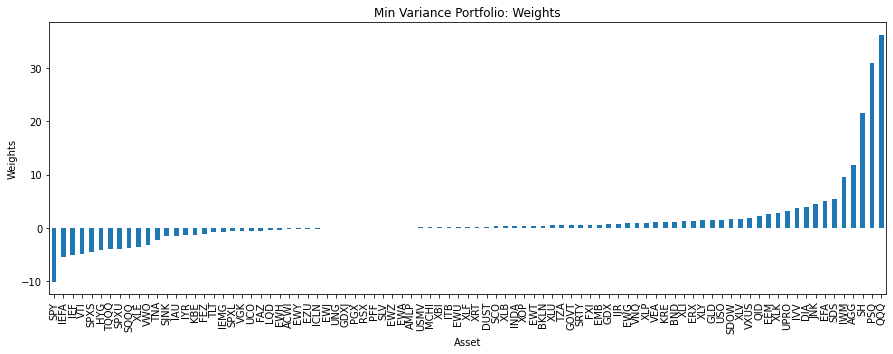

In [261]:
### MIN VAR
plot_series = pd.Series(x_m_perc, index=names).sort_values()
fig = plt.figure(figsize=(15,5))
plt.xlabel('Asset'); plt.ylabel("Weights"); plt.title("Min Variance Portfolio: Weights")
plot_series.plot(kind = 'bar'); plt.show();

In [238]:
### Calculating the value and readjust the portfolio for each week
minVar_W = np.array(x_m.reshape(89)[0])

return_weekly = []
value_weekly = [100]
value = 100

for i in range(len(test)-1):
    
    old_value = value
    
    ### Calculate the number of share at the end of each week (week i)
    share = minVar_W * value / np.array(test.iloc[i,])
    
    ### New portfolio's value @ week i+1
    value = np.sum(share * np.array(test.iloc[i+1,]))
    
    value_weekly.append(value)
    return_weekly.append((value - old_value)-1)

mu_minVar = np.array(return_weekly).mean()
print ("Mean Return:       ", mu_minVar)

sd_minVar = np.array(return_weekly).std()
print ("Volatility Return: ", sd_minVar)
print ("Sharp Ratio: ", round(mu_minVar / sd_minVar, 4) )
print ("(Min-Risk) Portfolio's Value at the end: ", round(value_weekly[len(value_weekly)-1],4))

Mean Return:        -0.9740607256622826
Volatility Return:  0.051583723329895664
Sharp Ratio:  -18.8831
(Min-Risk) Portfolio's Value at the end:  104.0465


## Port #2: CML Portfolio 

In [233]:
tao_mm = 1 / (l.T @ inv(E) @ mu).item()
x_mm = tao_mm * (inv(E) @ mu)
x_mm_perc = [x.item() * 100 for x in x_mm]

mu_mm = (mu.T @ x_mm).item()
var_mm = (x_mm.T @ E @ x_mm).item()
print ("Tangent Portfolio")
print ("Mean Return: ", mu_mm)
print ("Volatility:  ", math.sqrt(var_mm))
pd.DataFrame({"tickers":tickers, "weights":x_mm_perc}, index=tickers).sort_values('weights', ascending=False).T

Tangent Portfolio
Mean Return:  0.0010220439512371822
Volatility:   0.0015132293770516955


,AGG,QQQ,SPXU,IWM,IVV,BND,SDS,IJR,XLK,GOVT,USMV,VXUS,VGK,HYG,VNQ,SRTY,XLV,SQQQ,UPRO,XLY,KRE,BKLN,DIA,XLI,EEM,PGX,QID,SH,ERX,EWJ,XLP,XLU,ACWI,EWY,EWT,MCHI,ITB,SDOW,IAU,INDA,...,FXI,XOP,EWG,UNG,AMLP,ICLN,SPXL,IEFA,XRT,EZU,DUST,FEZ,GLD,TLT,SLV,SJNK,LQD,EFA,GDX,SCO,UCO,EWU,VWO,EMB,FAZ,PFF,XLE,KBE,JNK,TZA,VTI,IYR,TNA,IEMG,TQQQ,VEA,SPXS,IEF,PSQ,SPY
tickers,AGG,QQQ,SPXU,IWM,IVV,BND,SDS,IJR,XLK,GOVT,USMV,VXUS,VGK,HYG,VNQ,SRTY,XLV,SQQQ,UPRO,XLY,KRE,BKLN,DIA,XLI,EEM,PGX,QID,SH,ERX,EWJ,XLP,XLU,ACWI,EWY,EWT,MCHI,ITB,SDOW,IAU,INDA,...,FXI,XOP,EWG,UNG,AMLP,ICLN,SPXL,IEFA,XRT,EZU,DUST,FEZ,GLD,TLT,SLV,SJNK,LQD,EFA,GDX,SCO,UCO,EWU,VWO,EMB,FAZ,PFF,XLE,KBE,JNK,TZA,VTI,IYR,TNA,IEMG,TQQQ,VEA,SPXS,IEF,PSQ,SPY
weights,58.9643,58.9356,36.2792,23.7886,22.0041,18.6877,14.9995,14.4757,13.9775,13.1492,12.8844,12.0961,12.0133,11.5088,9.66205,8.51202,8.21464,8.1644,7.98344,7.52453,7.49024,7.30562,7.23814,6.56652,6.16983,5.7093,5.67282,4.68998,4.31822,4.14679,3.88505,3.66222,2.89697,2.86682,2.39455,1.97605,1.45799,1.41088,1.3004,1.29188,...,0.345926,0.137015,0.0839224,-0.134446,-0.16278,-0.263074,-0.365651,-0.501563,-0.529039,-0.737961,-0.809823,-1.02983,-1.31779,-1.34277,-1.41313,-1.69599,-2.01144,-2.06463,-2.10485,-2.23607,-2.54662,-3.08673,-3.86451,-4.17239,-6.35315,-6.54305,-6.90856,-8.90112,-11.3474,-11.657,-12.5716,-15.4485,-15.9675,-16.5494,-21.5741,-24.3479,-27.1987,-43.7455,-49.1159,-53.7351


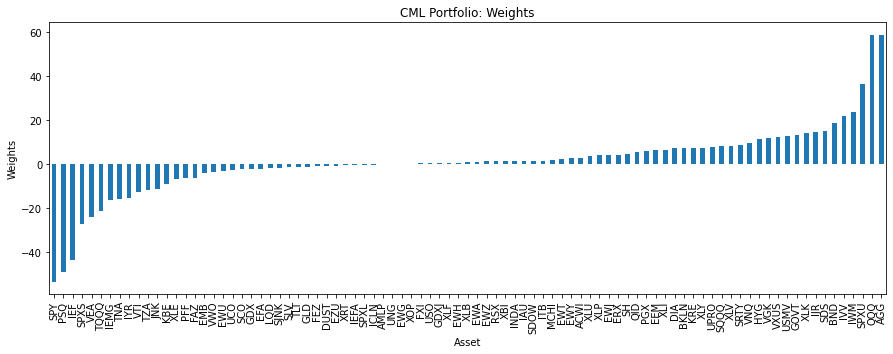

In [262]:
### CML
plot_series = pd.Series(x_mm_perc, index=names).sort_values()
fig = plt.figure(figsize=(15,5))
plt.xlabel('Asset'); plt.ylabel("Weights"); plt.title("CML Portfolio: Weights")
plot_series.plot(kind = 'bar'); plt.show();

In [243]:
### Calculating the value and readjust the portfolio for each week
CML_W = np.array(x_mm.reshape(89)[0])

return_CML = []
value_CML = [100]
value = 100

for i in range(len(test)-1):
    
    old_value = value
    
    ### Calculate the number of share at the end of each week (week i)
    share = CML_W * value / np.array(test.iloc[i,])
    
    ### New portfolio's value @ week i+1
    value = np.sum(share * np.array(test.iloc[i+1,]))
    
    value_CML.append(value)
    return_CML.append((value - old_value)-1)

mu_CML = np.array(return_CML).mean()
print ("Mean Return:       ", mu_CML)

sd_CML = np.array(return_CML).std()
print ("Volatility Return: ", sd_CML)
print ("Sharp Ratio: ", round(mu_CML / sd_CML, 4) )
print ("CML Portfolio's Value at the end: ", round(value_CML[len(value_CML)-1],4))

Mean Return:        -0.8884326361203873
Volatility Return:  0.16821941845361751
Sharp Ratio:  -5.2814
CML Portfolio's Value at the end:  117.4045


## Port #3: 1/N Portfolio


In [264]:
num_assets = len(tickers)
naive_W = np.array(num_assets*[1./num_assets,])
pd.DataFrame({"tickers":tickers, "weights":naive_W}, index=tickers).sort_values('weights', ascending=False).T

,SPY,EWG,XBI,EMB,IJR,DUST,PSQ,UCO,ICLN,UNG,BND,RSX,ERX,EZU,UPRO,SJNK,USO,PFF,GOVT,IEF,AGG,VNQ,INDA,VGK,XRT,VXUS,PGX,XLY,USMV,KBE,ITB,EWA,AMLP,DIA,EWU,VTI,SCO,MCHI,ACWI,FAZ,...,IEMG,FXI,TZA,IAU,EFA,GDX,SPXU,IWM,EWZ,SLV,HYG,TQQQ,SPXS,XLE,QQQ,EEM,XLF,XLU,XLI,VWO,IEFA,SRTY,EWJ,BKLN,JNK,SPXL,GDXJ,VEA,XOP,XLK,SH,XLV,XLP,GLD,KRE,QID,TNA,SDOW,TLT,FEZ
tickers,SPY,EWG,XBI,EMB,IJR,DUST,PSQ,UCO,ICLN,UNG,BND,RSX,ERX,EZU,UPRO,SJNK,USO,PFF,GOVT,IEF,AGG,VNQ,INDA,VGK,XRT,VXUS,PGX,XLY,USMV,KBE,ITB,EWA,AMLP,DIA,EWU,VTI,SCO,MCHI,ACWI,FAZ,...,IEMG,FXI,TZA,IAU,EFA,GDX,SPXU,IWM,EWZ,SLV,HYG,TQQQ,SPXS,XLE,QQQ,EEM,XLF,XLU,XLI,VWO,IEFA,SRTY,EWJ,BKLN,JNK,SPXL,GDXJ,VEA,XOP,XLK,SH,XLV,XLP,GLD,KRE,QID,TNA,SDOW,TLT,FEZ
weights,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,...,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236,0.011236


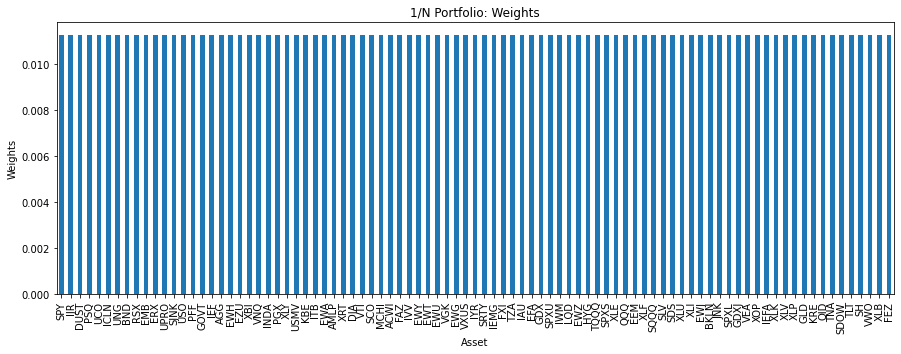

In [265]:
### 1/N portfolio
plot_series = pd.Series(naive_W, index=names).sort_values()
fig = plt.figure(figsize=(15,5))
plt.xlabel('Asset'); plt.ylabel("Weights"); plt.title("1/N Portfolio: Weights")
plot_series.plot(kind = 'bar'); plt.show();

In [240]:
### Calculating the value and readjust the portfolio for each week
return_naive = []
value_naive = [100]
value = 100

for i in range(len(test)-1):
    
    old_value = value
    
    ### Calculate the number of share at the end of each week (week i)
    share = naive_W * value / np.array(test.iloc[i,])
    
    ### New portfolio's value @ week i+1
    value = np.sum(share * np.array(test.iloc[i+1,]))
    
    value_naive.append(value)
    return_naive.append( (value / old_value) - 1)

mu_naive = np.array(return_naive).mean()
print ("Mean Return:       ", mu_naive)
sd_naive = np.array(return_naive).std()
print ("Volatility Return: ", sd_naive)

print ("Sharp Ratio: ", round(mu_naive / sd_naive, 4) )
print ("1/N Portfolio's Value at the end: ", round(value_naive[len(value_naive)-1],4))

Mean Return:        0.0009145643194847337
Volatility Return:  0.008253334497849723
Sharp Ratio:  0.1108
1/N Portfolio's Value at the end:  114.7155


## Comparison: Portfolio Value and Return

Text(0, 0.5, '$')

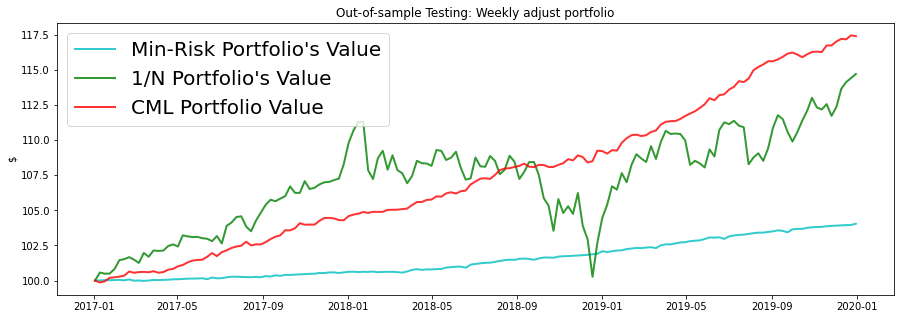

In [263]:
### Portfolio's Value
plt.figure(figsize=(15, 5))
plt.title("Out-of-sample Testing: Weekly adjust portfolio")
plt.plot(test.index, value_weekly, lw=2, alpha=0.8, color = 'c', label="Min-Risk Portfolio's Value")
plt.plot(test.index, value_naive, lw=2, alpha=0.8, color = 'g', label="1/N Portfolio's Value")
plt.plot(test.index, value_CML, lw=2, alpha=0.8, color = 'red', label="CML Portfolio Value")
plt.legend(loc='upper left', fontsize=20)
plt.ylabel("$")

***
# Simulation: 1000000 portfolios
Condition: $\forall x \in \overrightarrow{x}, x \ge 0$ i.e. no short position.

In [222]:
### Simulating portfolios
num_port = 1000000

# Creating an empty array to store portfolio weights / Returns / Risk / Sharpe
all_wts = np.zeros((num_port, len(eft_close.columns)))
port_returns = np.zeros((num_port))
port_risk = np.zeros((num_port))
sharpe_ratio = np.zeros((num_port))

# Simulation Process
for i in tqdm(range(num_port)):
  
  # Randomize the weight allocation 
  x_m_i = np.random.uniform(size = len(eft_close.columns))
  x_m_i = x_m_i/np.sum(x_m_i)
  
  # Portfolio Returns
  mu_m = (mu.T @ x_m_i).item()
  var_m = (x_m_i.T @ E @ x_m_i).item()
  
  # Portfolio Sharpe Ratio: Assuming 0% Risk Free Rate
  sr = mu_naive / sd_naive

  # Updating the list
  all_wts[i,:] = x_m_i
  port_returns[i] = mu_m
  port_risk[i] = var_m
  sharpe_ratio[i] = sr

### NOTE THAT THIS CAN BE SOLVED ANALYTICALLY!!!
### Three Optimal Portfolio
names = eft_close.columns

min_var = all_wts[port_risk.argmin()]
mu_min_var = (mu.T @ min_var).item()
var_min_var = (min_var.T @ E @ min_var).item()

max_sr  = all_wts[sharpe_ratio.argmax()]
mu_opt = (mu.T @ max_sr).item()
var_opt = (max_sr.T @ E @ max_sr).item()

max_ret = all_wts[port_returns.argmax()]
mu_max_ret = (mu.T @ max_ret).item()
var_max_ret = (max_ret.T @ E @ max_ret).item()

print (sharpe_ratio.max())
print (port_risk.min())
print (port_returns.max())

100%|██████████| 1000000/1000000 [00:46<00:00, 21306.88it/s]

0.11081149318775449
1.4171057057361974e-05
0.0016188299305875014


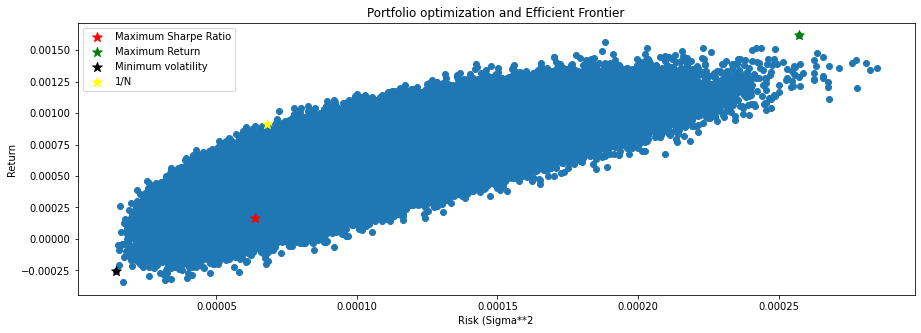

In [226]:
# Bullet curve plot (Efficient Frontier)
fig = plt.figure(figsize=(15,5))
plt.title("Portfolio optimization and Efficient Frontier"); plt.xlabel("Risk (Sigma**2)"); plt.ylabel("Return")
plt.scatter(port_risk, port_returns); 
plt.scatter(var_opt, mu_opt, marker='*',color='red',s=100, label='Maximum Sharpe Ratio')
plt.scatter(var_max_ret, mu_max_ret, marker='*',color='green',s=100, label='Maximum Return')
plt.scatter(var_min_var, mu_min_var, marker='*',color='black',s=100, label='Minimum volatility')
plt.scatter(sd_naive**2, mu_naive, marker='*',color='orange',s=100, label='1/N')
plt.legend(); plt.show();

# Asset Allocation

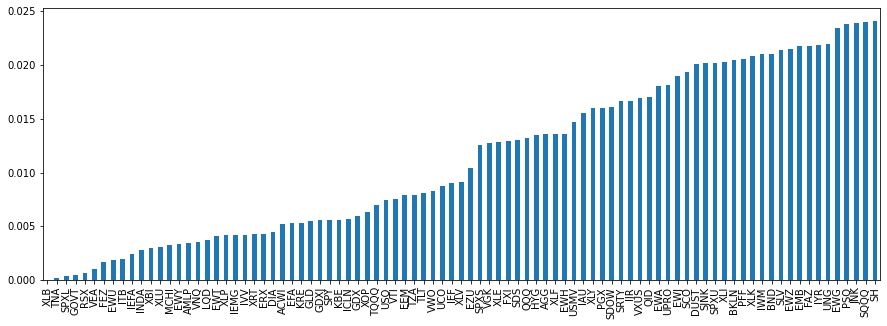

In [181]:
### MIN VAR
plot_series = pd.Series(min_var, index=names).sort_values()
fig = plt.figure(figsize=(15,5))
ax1.set_xlabel('Asset'); ax1.set_ylabel("Weights"); ax1.set_title("Min Variance Portfolio")
plot_series.plot(kind = 'bar'); plt.show();

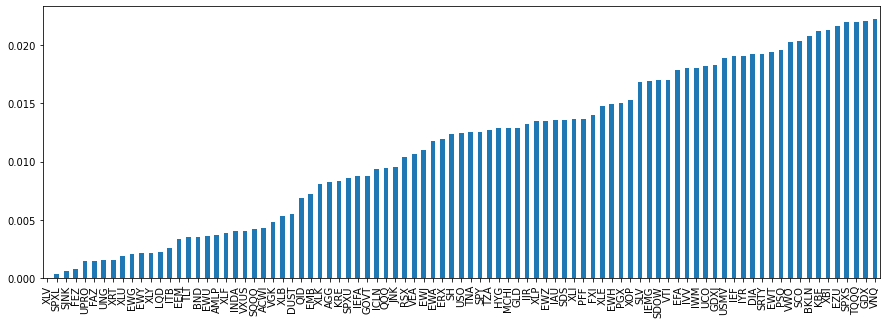

In [182]:
### Max Sharpe Ratio
plot_series = pd.Series(max_sr, index=names).sort_values()
fig = plt.figure(figsize=(15,5))
ax1.set_xlabel('Asset'); ax1.set_ylabel("Weights"); ax1.set_title("Maximum Sharpe Ratio")
plot_series.plot(kind = 'bar'); plt.show();

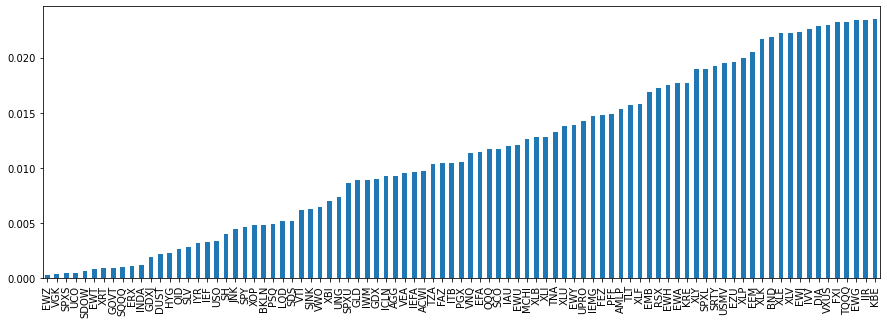

In [183]:
### Max Return
plot_series = pd.Series(max_ret, index=names).sort_values()
fig = plt.figure(figsize=(15,5))
ax1.set_xlabel('Asset'); ax1.set_ylabel("Weights"); ax1.set_title("Maximum Return")
plot_series.plot(kind = 'bar'); plt.show();